# **C-calculate_prcp_EOF.ipynb**

Author: Zhixian Yang

Email: [yangzhx28@mail2.sysu.edu.cn](mailto:yangzhx28@mail2.sysu.edu.cn) or [yimu01439@gmail.com](mailto:yimu01439@gmail.com)

GitHub: [https://github.com/koar-create](https://github.com/koar-create)

Date created: July 27th, 2023

Last modified: July 27th, 2023

<br><br>

---

<br><br>

## **Description**
This document is a Jupyter Notebook designed for an exercise derived from the "Computational Tools for Climate Science 2023" course offered by Climatematch Academy. The code presented here comprises a combination of materials provided in the course and code obtained from online sources.

# **<font color='red' size=5>0. download and import packages</font>**

In [1]:
import platform
if platform.system() == 'Linux':
    !pip install cdsapi --quiet
    !pip install imageio[ffmpeg] --quiet
    !pip install imageio[pyav] --quiet

In [2]:
# 1. downloaad
import cdsapi                         # download from Climate Data Store, ECMWF
import pooch, urllib.request          # download from any available URL
import s3fs, boto3, botocore          # download from S3 server, Amazon Web Service
from pythia_datasets import DATASETS  # download certain content from pythia

# 2. useful toolkits
from itertools import product
import os, sys, glob, time, tempfile

# 3. read and write
import h5py

# 4. data processing
from scipy import stats
from datetime import datetime, timedelta
import numpy as np, pandas as pd, xarray as xr

# 5. image processing
import imageio
import cartopy.io.shapereader as shapereader
import matplotlib as mpl, matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs, cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
second_per_day = 86400

# **<font color='red' size=5>1. read data</font>**

### **<font size=4>Yang: here we use the ERA5 ReAnalysis Data under the folder `Data/ERA5/monthly/single_level/1979_2023_SM.nc` with time resolution of 1-month.</font>**

In [4]:
file_path = os.path.join('Data', 'ERA5', 'monthly', 'single_level', '1979-2023_SM.nc')
ds = xr.open_dataset(file_path).sel(expver=1).squeeze()
ds

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 101, time: 534)
Coordinates:
  * longitude  (longitude) float32 90.0 90.25 90.5 90.75 ... 129.5 129.8 130.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -9.5 -9.75 -10.0
    expver     int32 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-06-01
Data variables:
    sst        (time, latitude, longitude) float32 ...
    cp         (time, latitude, longitude) float32 ...
    crr        (time, latitude, longitude) float32 ...
    lsp        (time, latitude, longitude) float32 ...
    lsrr       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-27 21:17:53 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

# **<font color='red' size=5>2. calculate precipitation EOF</font>**

In [21]:
interested_region = [90.0, 130.0, -10.0, 15.0]

var_raw = ds.crr.sel(time=slice('1979-01', '2023-05'), 
                     latitude=slice( interested_region[-1], interested_region[-2]), 
                     longitude=slice(interested_region[ 0], interested_region[ 1])) * second_per_day
var_anom = var_raw - var_raw.mean('time')

In [22]:
mode = 'anom'
var = var_raw if mode == 'raw' else var_anom

full_zero_var = np.where(np.isnan(var), 0.0, var)
print(f"full_zero_var has the shape of {full_zero_var.shape}.")

full_zero_var has the shape of (533, 101, 161).


## <font color='blue'>1st and 2nd EOF of precipitation rate</font>

# **<font color='red' size=5>0. download and import packages</font>**

In [23]:
n, N, P = full_zero_var.shape

var_2D = full_zero_var.reshape(n, N * P).transpose()  # reshape and transpose it, making it has the shape of (NP, n)
print(f"val_2D has the shape of {var_2D.shape}.")

# test: does using the reshape() function disrupt the order of indices?
print('reshape() function will not disrupt the order of indices: ', np.array_equal(var_2D.transpose().reshape(n, N, P), full_zero_var))

if N * P >= 5000:
    # if N*P is large, use this method to obtain eigenvalues and eigenvectors.
    smol_X = var_2D.transpose() @ var_2D
    smol_eigvals, smol_eigvecs = np.linalg.eig(smol_X)

    eigvals = smol_eigvals
    eigvecs = np.array([[] for i in range(N * P)])
    for i in range(n):
        new_vec = (var_2D @ smol_eigvecs[:, i]).reshape(N * P, 1) / np.sqrt(eigvals[i])
        eigvecs = np.concatenate([eigvecs, new_vec], axis=1)    
else:
    X = var_2D @ var_2D.transpose()
    eigvals, eigvecs = np.linalg.eig(X)

val_2D has the shape of (16261, 533).
reshape() function will not disrupt the order of indices:  True


In [24]:
sorted_indices = np.argsort(eigvals)[::-1]

# order eigenvalues in descending order
sorted_eigenvals = eigvals[sorted_indices]

# order eigenvectors in descending order, that is EOF. 
EOF = eigvecs[:, sorted_indices]
PC = EOF.transpose() @ var_2D

EOF1 = EOF[:, 0].reshape(N, P)
EOF2 = EOF[:, 1].reshape(N, P)
PC1 = PC[0, :]
PC2 = PC[1, :]
std_PC1 = (PC1 - PC1.mean()) / PC1.std()
std_PC2 = (PC2 - PC2.mean()) / PC2.std()

print(f'Explained Variance of PC1 is {(sorted_eigenvals[0]/sum(sorted_eigenvals)):.02f}. ')
print(f'Explained Variance of PC2 is {(sorted_eigenvals[1]/sum(sorted_eigenvals)):.02f}. ')

Explained Variance of PC1 is 0.42. 
Explained Variance of PC2 is 0.14. 


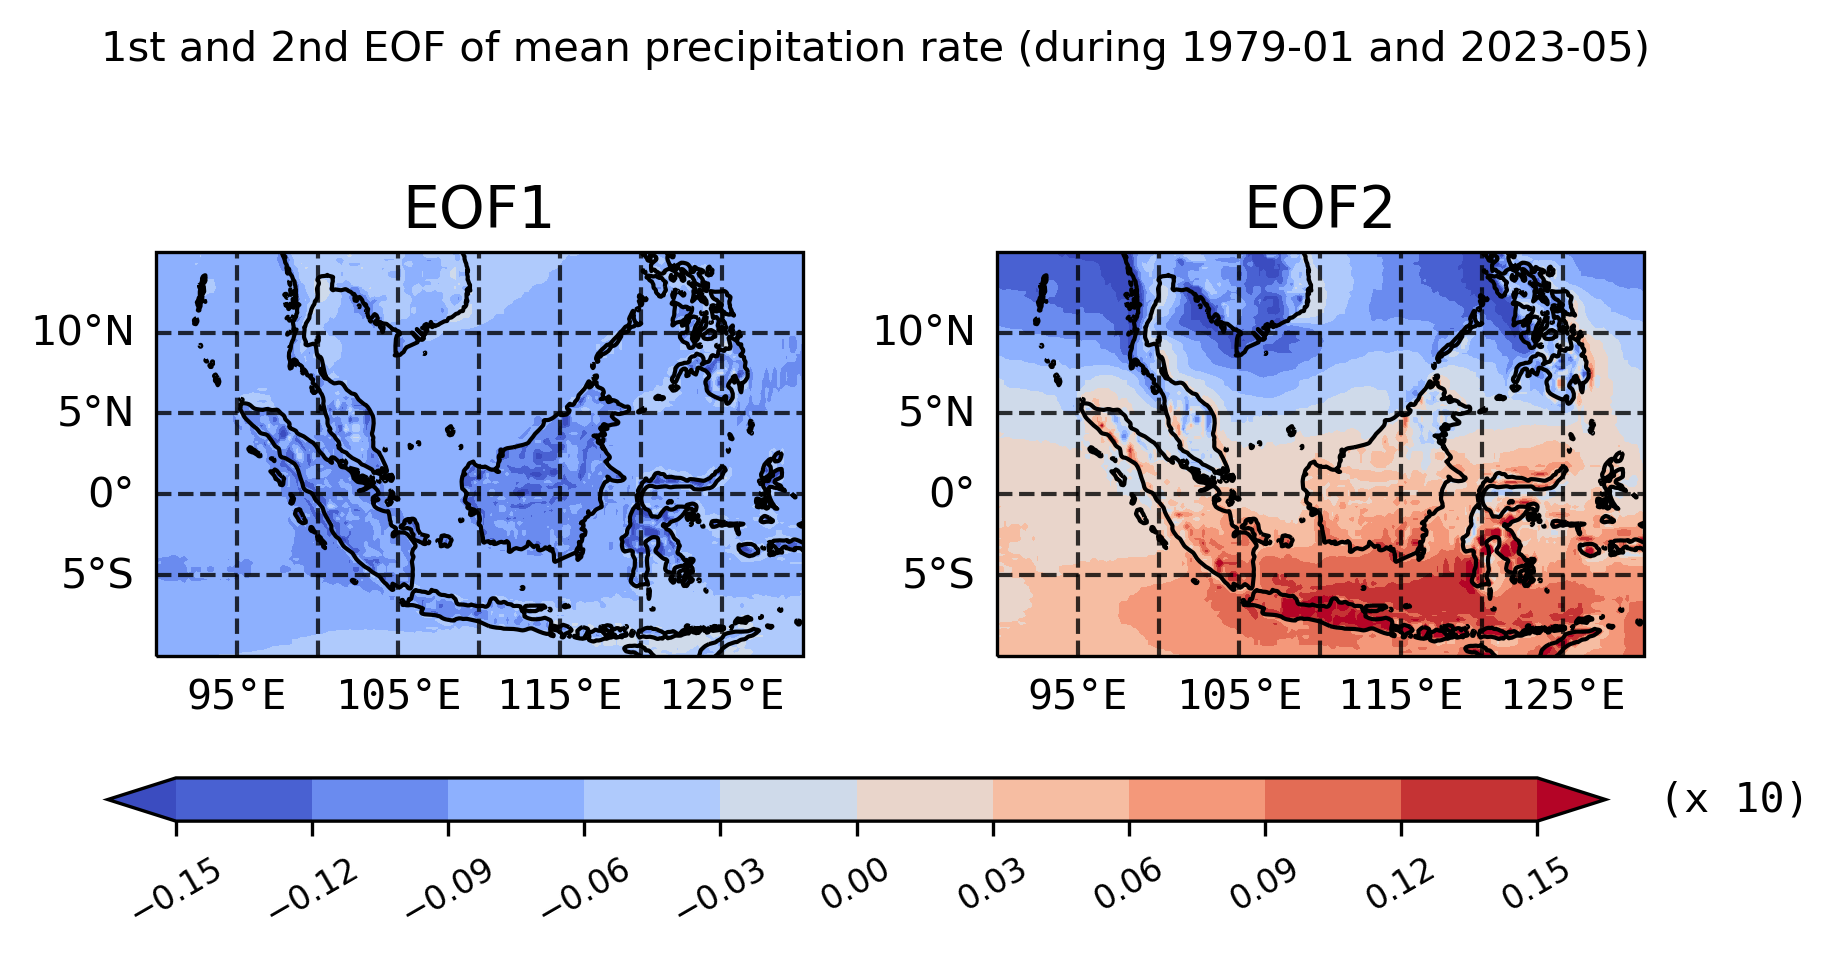

In [14]:
# plot the 1st mode of EOF

title_eof = {'raw' : '1st and 2nd EOF of mean precipitation rate (during 1979-01 and 2023-05)', 
             'anom': '1st and 2nd EOF of mean precipitation rate anomalies (during 1979-01 and 2023-05)'}
picname_eof = {'raw' : 'EOF-mean_prcp.png', 
               'anom': 'EOF-mean_prcp_anom.png'}

scale = 10
vmin, vmax = -0.15, 0.15
interested_region = [var.longitude.min(), var.longitude.max(), var.latitude.min(), var.latitude.max()]
proj = ccrs.PlateCarree(central_longitude=110.0)
fig, axs = plt.subplots(ncols=2, dpi=300, subplot_kw={'projection': proj})

for ax in axs:
    ax.coastlines()
    ax.set_extent(interested_region, crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='k', alpha=0.8, linewidth=1, linestyle='dashed', draw_labels=True, x_inline=False, y_inline=False)
    gl.xformatter, gl.yformatter = LongitudeFormatter(), LatitudeFormatter()
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style, gl.xlabel_style = {'family':'Monospace', 'size':10}, {'family':'Monospace', 'size':10}

im1 = axs[0].contourf(var.longitude, var.latitude, scale * EOF1, transform=ccrs.PlateCarree(), 
                      cmap='coolwarm',
                      levels=np.linspace(vmin, vmax, 11), extend='both')
im2 = axs[1].contourf(var.longitude, var.latitude, scale * EOF2, transform=ccrs.PlateCarree(), 
                      cmap='coolwarm',
                      levels=np.linspace(vmin, vmax, 11), extend='both')
axs[0].set_title('EOF1', fontdict={'size':14})
axs[1].set_title('EOF2', fontdict={'size':14})

cax = fig.add_axes([0.1, 0.3, 0.78, 0.03])
cax.text(1.2, 0.5, f'(x {scale})', fontsize=10, family='Monospace', va='center', ha='right' , rotation='horizontal', rotation_mode='anchor', transform=cax.transAxes)
cbar = fig.colorbar(im1, orientation='horizontal', ticks=np.linspace(vmin, vmax, 11), cax=cax)
cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=30, size=8)

fig.text(0.5, 0.85, title_eof[mode],
       fontsize=10, va='top', ha='center' , rotation='horizontal', rotation_mode='anchor')
fig.subplots_adjust(top=1, wspace=0.3)
plt.savefig(os.path.join('Figure', picname_eof[mode]), dpi=100)
plt.show()

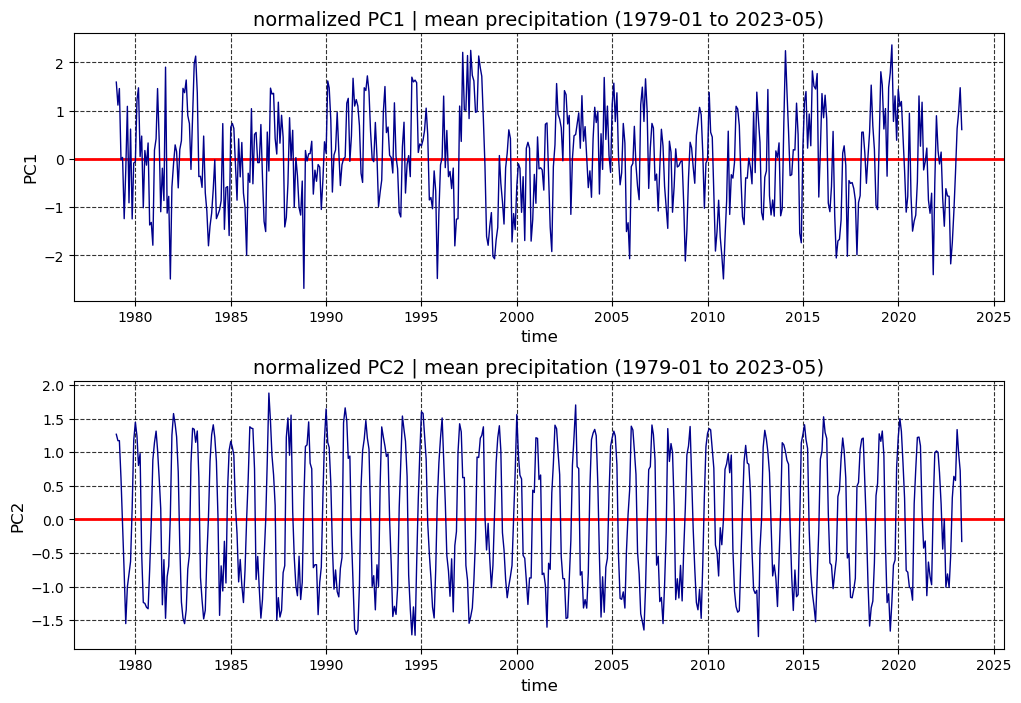

In [20]:
# plot the 1st principal component of sst anomalies

title_pc = {'raw' : 'mean precipitation (1979-01 to 2023-05)', 
            'anom': 'mean precipitation anomalies (1979-01 to 2023-05)'}
picname_pc = {'raw' : 'PC-mean_prcp.png', 
              'anom': 'PC-mean_prcp_anom.png'}

fig, axs = plt.subplots(nrows=2, figsize=(12, 8), dpi=100)

for ax in axs:
    ax.grid(True, linestyle='dashed', linewidth=0.8, color='k', alpha=0.8)
    ax.axhline(0.0, linewidth=2, linestyle='-', color='red')
    ax.set_xlabel('time', fontdict={'size':12})

axs[0].plot(var.time, std_PC1, linewidth=1, linestyle='-', color='darkblue')
axs[1].plot(var.time, std_PC2, linewidth=1, linestyle='-', color='darkblue')

axs[0].set_title('normalized PC1 | ' + title_pc[mode], fontdict={'size':14})
axs[1].set_title('normalized PC2 | ' + title_pc[mode], fontdict={'size':14})
axs[0].set_ylabel('PC1', fontdict={'size':12})
axs[1].set_ylabel('PC2', fontdict={'size':12})

fig.subplots_adjust(hspace=0.3)

plt.savefig(os.path.join('Figure', picname_pc[mode]), dpi=100)